# Mashable Article Research

### Predicting crucial article features to maximize shares using Regression

Mashable is an online news platform that gets attention when readers share its articles. Our goal was to build a model to predict how many times an article would be shared, based on its different features. The dataset we used comes from Mashable and includes a variety of article characteristics like word counts, number of images, and topic information. We wanted to see which features matter most and how well we can predict the number of shares an article will receive.

### Exploratory Data Analysis (EDA)

First, we looked at the main variable we care about: the number of shares. We plotted it and saw that it was not nicely spread out—in fact, it was very skewed. To fix this, we tried taking the log of the shares. After taking the log, the distribution looked more balanced. This means it’s easier for our models to spot patterns.

We then tried a simple linear regression model on the original data and picked out which features seemed most important. We also used a regression tree to find which predictors stood out. Both approaches helped us figure out a set of features that seemed to have a strong relationship with article shares. Some of these features included things like how long the article’s title is, how many unique words it has, the keyword metrics, and certain topic-related variables.

We also looked more closely at some of these features by creating scatter plots. For example, we compared certain keyword averages and word counts with the number of shares to see if there was any clear pattern. This helped us confirm that these factors are worth keeping in our final model.

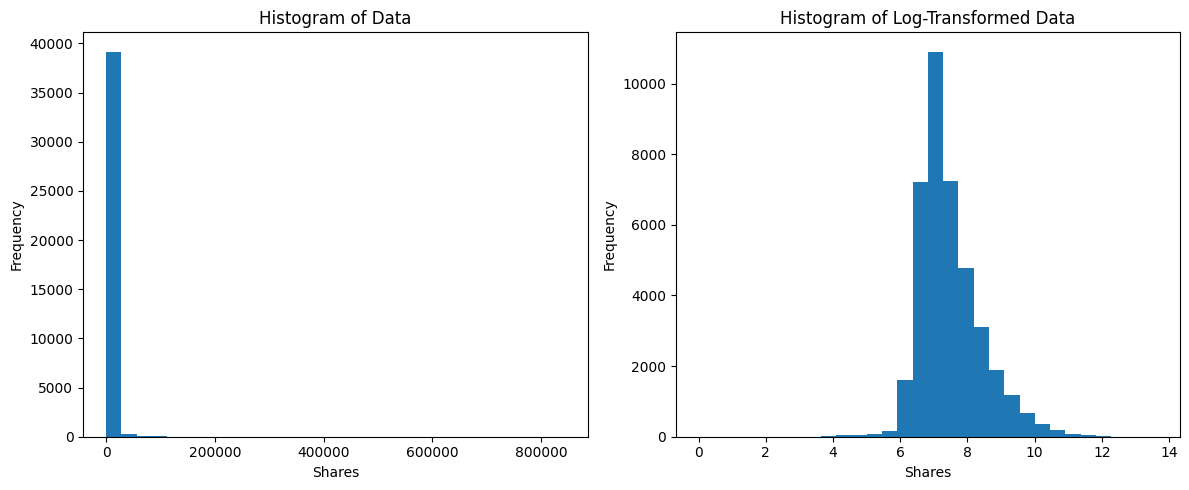

Final set of predictors we used in our models:

- `n_tokens_title`
- `n_unique_tokens`
- `num_hrefs`
- `average_token_length`
- `kw_min_avg`
- `kw_max_avg`
- `kw_avg_avg`
- `self_reference_min_shares`
- `self_reference_max_shares`
- `LDA_03`
- `avg_negative_polarity`

## Linear Regression Model Report


After variable transformations and the addition of higher-order terms, the Lasso regression model finished with an in-sample R² of `0.107` and an out-of-sample R² of `0.118`. Key predictors driving the model's results include n_tokens_title, n_unique_tokens, num_hrefs, average_token_length, and LDA_03. These features, which relate to content length, structure, and topic modeling, appear to have a strong impact on predicting shares. In terms of residuals, the model's performance is decent, with training and test set MAE and RMSE values around 7.5. While these results indicate the Lasso model is not perfect, it does provide some useful insights into which factors influence share performance, and could still be helpful for future predictions, especially with further tuning. The R² value seems decent for a dataset with such high variability and unpredictability.

Additionally, a normal linear regression model was trained on all predictors then tuned until only predictors with `p < 0.05` remained. It had even better in-sample and out-of-sample R², `0.115` and `0.126` respectively. The predictors with the largest coefficients were `kw_avg_avg`, `kw_max_avg`, and the interaction between `n_unique_tokens` and `avg_negative_polarity`. Each of these predictors had a significantly larger effect on shares than the others, although there were many other significant predictors. Once again, this R² value doesn't indicate that our model has the power to tell the future per se, but it will certainly return useful results to predict future shares.

## Regression Tree Model Report


An initial Regression tree fit the data poorly, resulting in an out of sample R^2 value of `0.0063`.

Then, we did cost-complexity pruning to improve generalization. We calculated the out-of-sample R^2 value for each pruned tree. The highest R^2 model we were able to attain with this method was an out of sample R2 of `0.07749717`.

Then, we examined feature importances from the pruned tree to find which predictors had the greatest influence. The results are as follows.

| Feature                    | Importance            |
|----------------------------|-----------------------|
| n_tokens_title            | 0.014987921782418472  |
| n_tokens_content          | 0.10232590152660842   |
| n_unique_tokens           | 0.04403661962836678   |
| n_non_stop_words          | 0.14263598348223977   |
| n_non_stop_unique_tokens  | 0.02732702696242169   |
| num_hrefs                 | 0.09895577473044019   |
| num_self_hrefs            | 0.19910082486393102   |
| num_imgs                  | 0.10287959490785652   |
| num_videos                | 0.08546822339066752   |
| average_token_length      | 0.11968813130563771   |
| num_keywords              | 0.06259399741941177   |

This table shows that all features are important, with no clear predictors that stand above the rest.

Finally, we used random forest regression to attempt to further hone our tree model. This resulted in a disappointing out of sample R2 value of `-0.025523`. Overall, tree regression doesn't provide a reliable model for this dataset.

## Conclusion



When comparing all our models, the linear regression model turned out to be the best. It had an out-of-sample R² around `0.126`, which might not seem like a lot, but is high enough to clarify best practices for motivating people to share articles.

We now know that focusing on the right types of keywords, having a balanced content structure, and considering certain content topics (as suggested by the LDA features) could help boost shares. This doesn’t mean you can perfectly predict the future, but these insights can help editors when they create content. They might pay more attention to the length of titles, the variety of words, or certain keyword metrics that seemed to matter for higher shares.

In the end, the linear regression model is the one we’d go with. We have moderate confidence in what it tells us. We recommend using it along with human judgment and maybe adding more data and better features in the future. Over time, as Mashable gathers more data and tries out more advanced methods, they might improve their predictions further. For now, our final model gives them at least some reliable insights into what might make an article more shareable.

# Code used for analysis

## EDA (Close section to hide code)

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_auc_score
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

import warnings
warnings.filterwarnings('ignore')

train_test_random_state = 123

In [192]:
def dropInsignificant(X, y):
	model = sm.OLS(y, X).fit()

	# Calculate reduced model
	mod_temp = model
	X_temp = X
	while max(mod_temp.pvalues[1:]) > 0.05 and (len(X_temp.columns) > 1):
		max_pvalue = np.argmax(mod_temp.pvalues[1:])+1
		X_temp = X_temp.drop(columns = X_temp.columns[max_pvalue])
		mod_temp = sm.OLS(y, X_temp).fit()
	model = mod_temp

	# Return reduced model
	return model, X_temp

In [193]:
def plotRelationships(axs, dataset, predictors, y):
    for i in range(len(predictors)):
        row = i // 2
        col = i % 2
        axs[row, col].scatter(dataset[predictors[i]], y)
        axs[row, col].set_title(f'{predictors[i]} vs. Shares')
        axs[row, col].set_xlabel(predictors[i])
        axs[row, col].set_ylabel('Shares')

In [194]:
# Import data
raw_data = pd.read_csv('OnlineNewsPopularity.csv')

In [195]:
# Separate into X and y
non_predictive_columns = ['url', 'timedelta']
target = ['shares']

X = raw_data.drop(columns=non_predictive_columns + target)
X_with_const = sm.add_constant(X)
y = raw_data['shares']

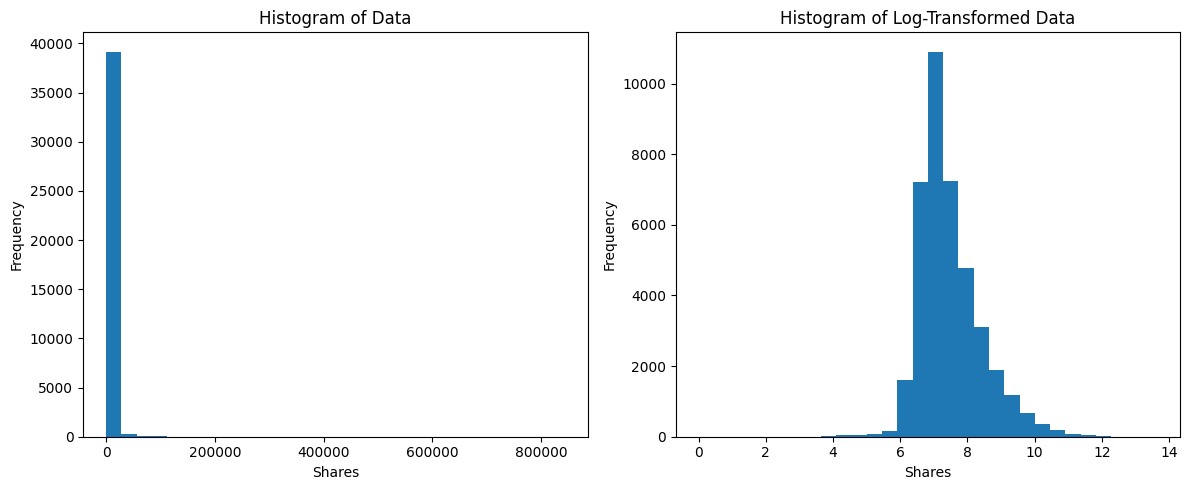

In [196]:
''' Plot target variable '''
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot original data histogram
axs[0].hist(y, bins=30)
axs[0].set_title('Histogram of Data')
axs[0].set_xlabel('Shares')
axs[0].set_ylabel('Frequency')

# Plot log-transformed data histogram
axs[1].hist(np.log(y), bins=30)
axs[1].set_title('Histogram of Log-Transformed Data')
axs[1].set_xlabel('Shares')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [197]:
''' List the statistically significant variables from linear regression '''
# Call function that drops the insignificant variables
linear_regressor_significant, X_significant = dropInsignificant(X_with_const, y)
linear_regressor_significant.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 shares   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     35.84
Date:                Wed, 11 Dec 2024   Prob (F-statistic):          6.96e-171
Time:                        10:58:23   Log-Likelihood:            -4.2692e+05
No. Observations:               39644   AIC:                         8.539e+05
Df Residuals:                   39618   BIC:                         8.541e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          -761.9668    543.610     -1.402      0.161   -1827.455     303.521
n_tokens_title                   83.6576     27.965      2.992      0.003      28.846     138.469
n_tokens_content                  0.5231      0.201      2.597      0.009       0.128       0.918
n_unique_tokens                1850.9289    896.486      2.065      0.039      93.794    3608.063
n_non_stop_words              -1240.3598    603.460     -2.055      0.040   -2423.155     -57.565
num_hrefs                        28.4821      6.317      4.509      0.000      16.100      40.864
num_self_hrefs                  -43.4907     17.060     -2.549      0.011     -76.929     -10.052
average_token_length           -310.3720     95.862     -3.238      0.001    -498.264    -122.480
data_channel_is_entertainment  -924.8867    164.829     -5.611      0.000   -1247.955    -601.818
data_channel_is_world          -420.7526    167.562     -2.511      0.012    -749.177     -92.328
kw_min_min                        3.9480      0.883      4.469      0.000       2.217       5.679
kw_min_max                       -0.0029      0.001     -2.706      0.007      -0.005      -0.001
kw_min_avg                       -0.3824      0.072     -5.344      0.000      -0.523      -0.242
kw_max_avg                       -0.1810      0.022     -8.385      0.000      -0.223      -0.139
kw_avg_avg                        1.6259      0.124     13.132      0.000       1.383       1.869
self_reference_min_shares         0.0228      0.003      6.776      0.000       0.016       0.029
self_reference_max_shares         0.0033      0.002      1.977      0.048    2.79e-05       0.007
weekday_is_tuesday             -498.3381    170.673     -2.920      0.004    -832.861    -163.815
weekday_is_wednesday           -347.5642    170.521     -2.038      0.042    -681.790     -13.338
weekday_is_thursday            -516.4325    171.608     -3.009      0.003    -852.789    -180.076
weekday_is_friday              -485.1050    185.679     -2.613      0.009    -849.041    -121.169
LDA_03                          715.3608    253.238      2.825      0.005     219.008    1211.714
global_subjectivity            2798.0362    752.442      3.719      0.000    1323.232    4272.840
global_rate_positive_words    -9193.4995   4120.297     -2.231      0.026   -1.73e+04   -1117.619
min_positive_polarity         -2127.0491    940.247     -2.262      0.024   -3969.956    -284.142
avg_negative_polarity         -1443.3232    520.862     -2.771      0.006   -2464.225    -422.421
==============================================================================
Omnibus:                   108739.560   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       5858180038.328
Skew

In [198]:
X_significant.columns

Index(['const', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'num_hrefs', 'num_self_hrefs',
       'average_token_length', 'data_channel_is_entertainment',
       'data_channel_is_world', 'kw_min_min', 'kw_min_max', 'kw_min_avg',
       'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'LDA_03', 'global_subjectivity', 'global_rate_positive_words',
       'min_positive_polarity', 'avg_negative_polarity'],
      dtype='object')

In [199]:
''' List the importance of the variables from a regression tree '''
# Fit tree
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X, y)

# Get feature importances
feature_importances = regressor.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [200]:
# Display top feature importances
num_important_features = 20
most_important = importance_df.iloc[:num_important_features]
most_important

,Feature,Importance
55,title_sentiment_polarity,0.127941
39,LDA_02,0.102886
40,LDA_03,0.078154
9,average_token_length,0.077426
25,kw_avg_avg,0.068318
46,rate_positive_words,0.062610
28,self_reference_avg_sharess,0.044785
27,self_reference_max_shares,0.029920
24,kw_max_avg,0.028454
38,LDA_01,0.027072


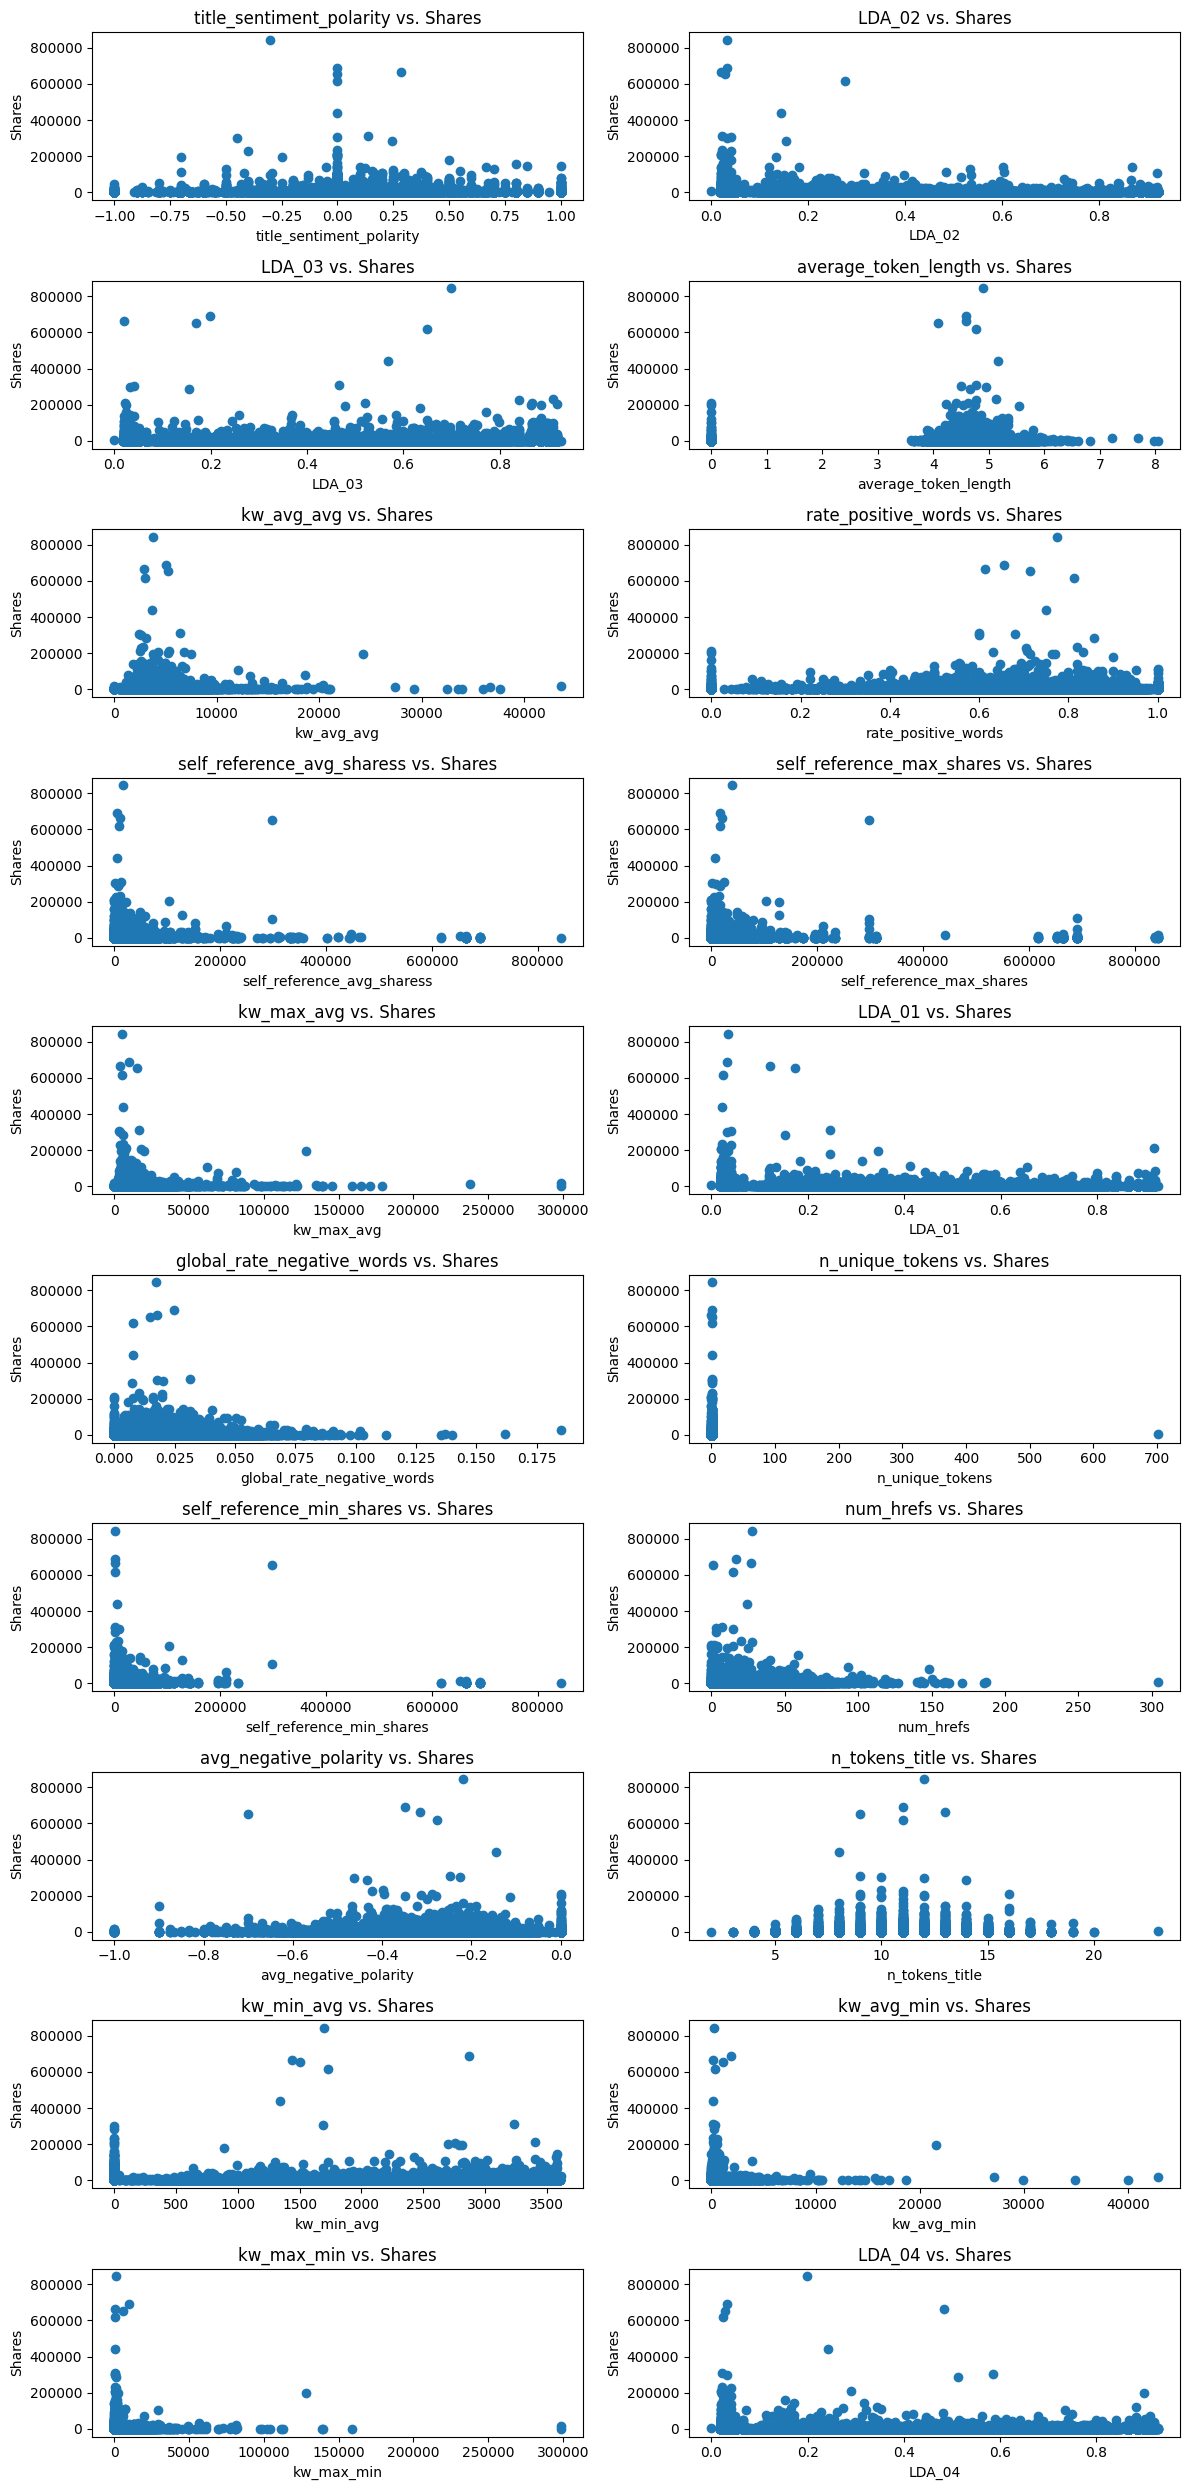

In [201]:
# Plot relationships between the most influential predictors and the target
fig, axs = plt.subplots(int(num_important_features/2), 2, figsize=(12, 25))
predictors = list(importance_df.iloc[0:num_important_features, 0])
plotRelationships(axs, X, predictors, y)

plt.tight_layout()
plt.show()

In [202]:
# Create the final list of predictors
significant_columns = X_significant.columns
important_columns = list(most_important.iloc[:, 0])
combined_columns = []
for col in significant_columns:
    if col in important_columns:
        combined_columns.append(col)

X_final = X[combined_columns]

In [203]:
# Print final predictors
X_final.columns

Index(['n_tokens_title', 'n_unique_tokens', 'num_hrefs',
       'average_token_length', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
       'self_reference_min_shares', 'self_reference_max_shares', 'LDA_03',
       'avg_negative_polarity'],
      dtype='object')

### EDA Report
* After observing the histogram of the target, we realized that a log transformation would be useful. Once the log transformation was performed, the distribution of the target became much less skewed.
* After gathering lists of the statistically significant predictors from the linear regression and the top 20 most important predictors from the regression tree, we chose the features that were in both lists and put them in our final list of predictors. We then used these predictors for the remainder of the project. These predictors can be found in the code cell above.
* Based on the decision tree feature importances, title_sentiment_polarity, LDA_02, and LDA_03 have the largest impact on shares. data_channel_is_entertainment, global_subjectivity, and avg_negative_polarity were all predictors with extremely low p-values and large coefficient, suggesting that they were some of the most important factors in the linear regression model.

## Linear Regression Modeling

### Splitting the Data into Training and Testing Sets

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


### Exploring Transformations of the Target and Other Variables

In [205]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

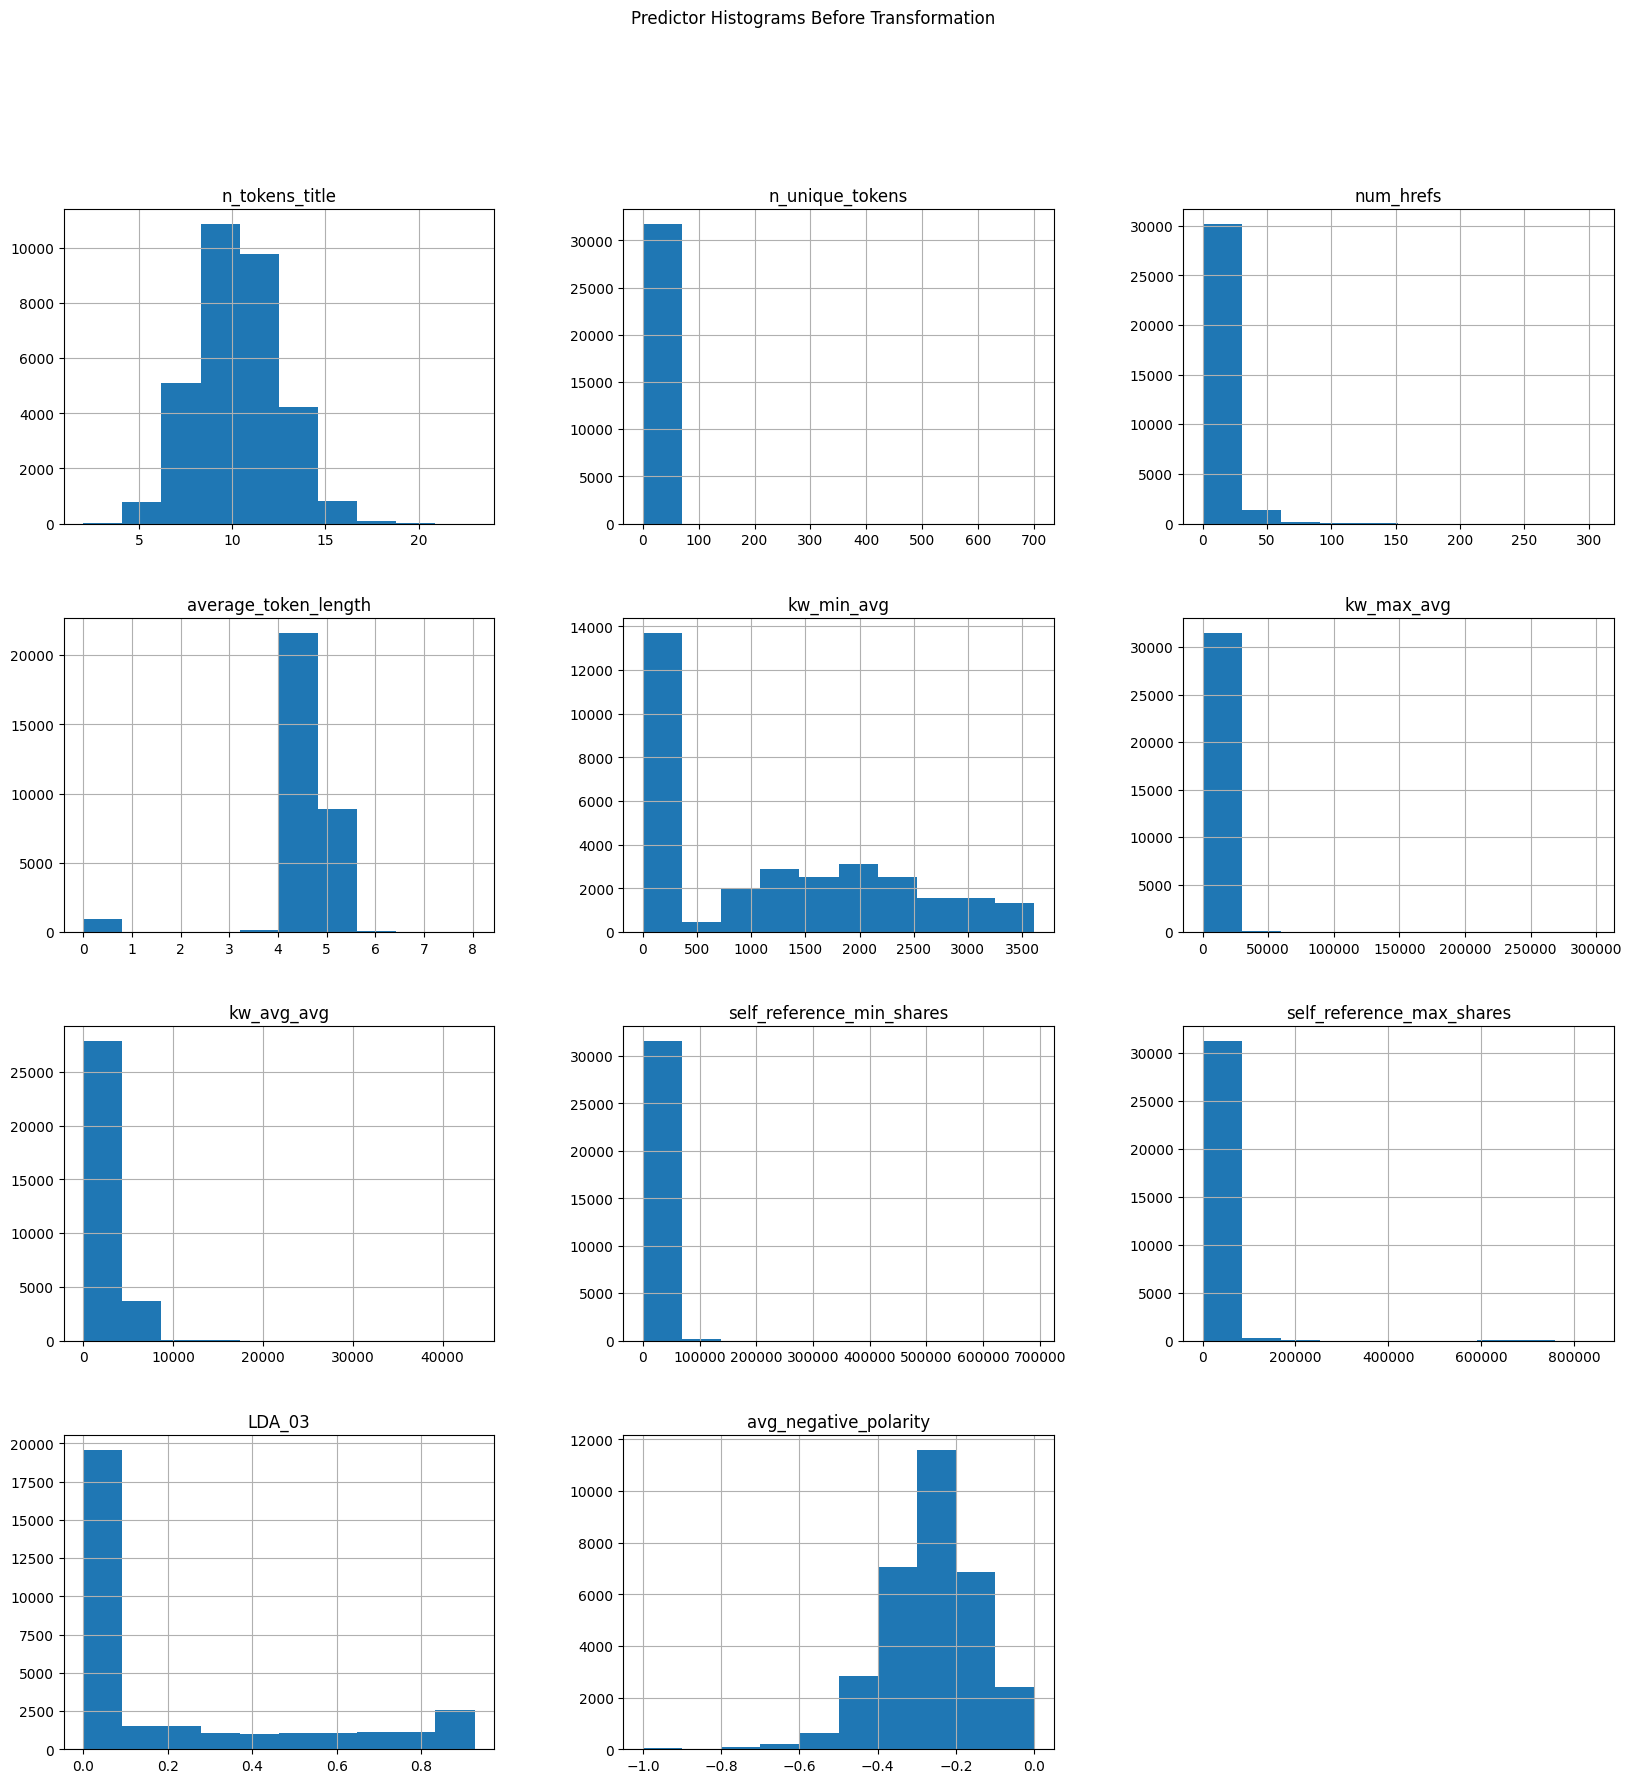

In [206]:
X_train.hist(figsize=(20, 20))
plt.suptitle('Predictor Histograms Before Transformation')
plt.show()
# Based on these graphs, a log transformation may be indicated for n_unique_tokens, num_hrefs, kw_max_avg, kw_avg_avg,
# self_reference_min_shares, self_reference_max_shares, and n_unique_tokens

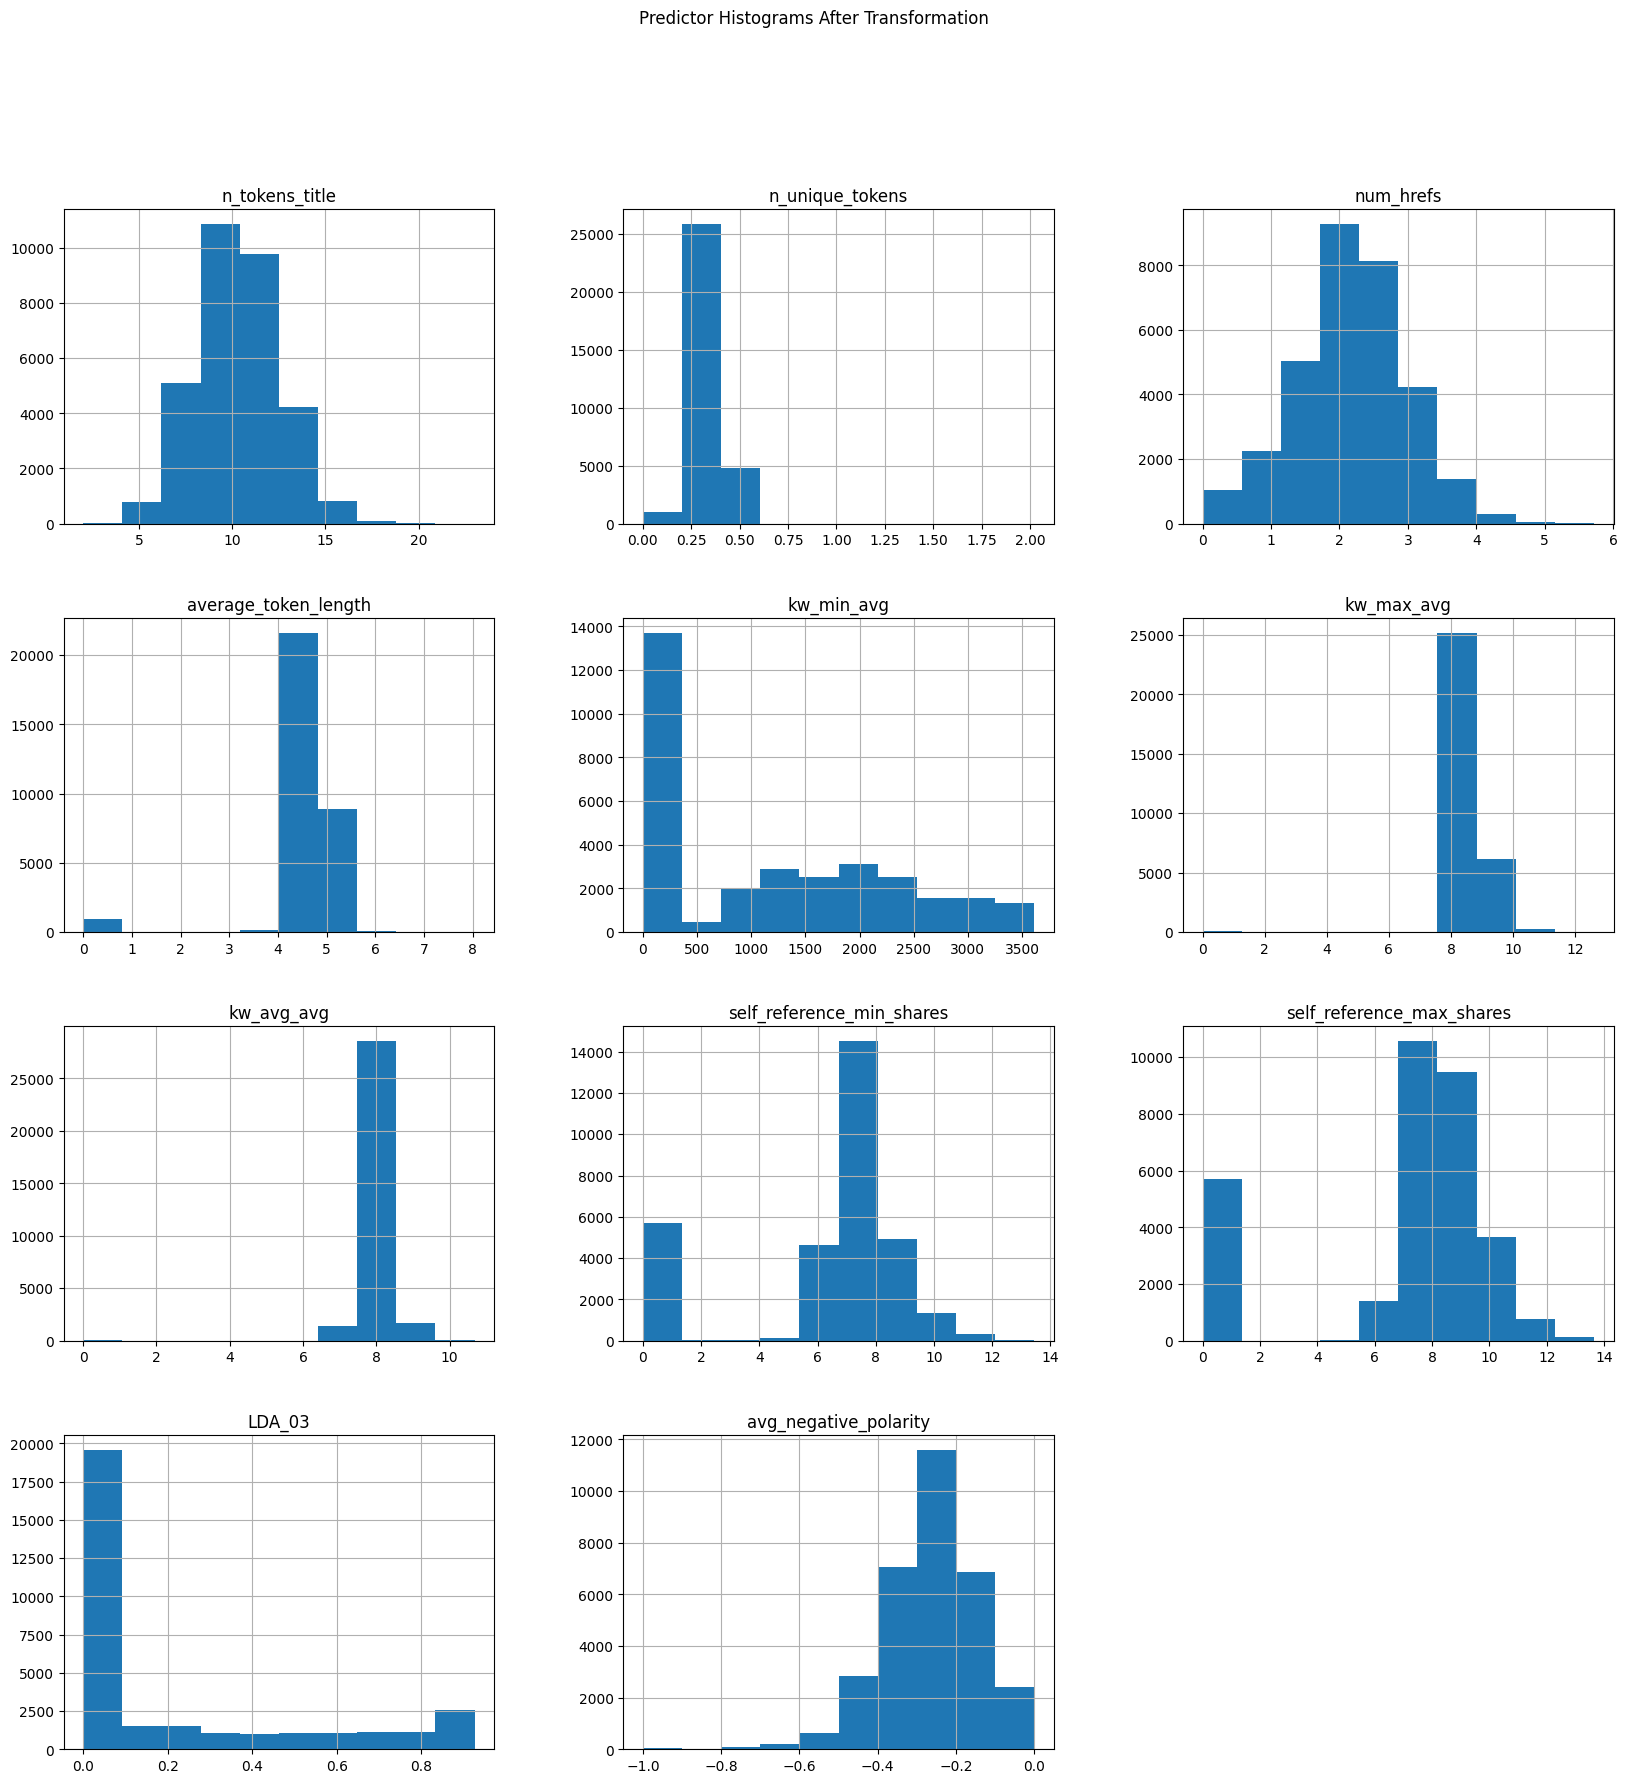

In [207]:
X_train['n_unique_tokens'] = np.log1p(X_train['n_unique_tokens'])
X_train['num_hrefs'] = np.log1p(X_train['num_hrefs'])
X_train['kw_max_avg'] = np.log1p(X_train['kw_max_avg'])
X_train['kw_avg_avg'] = np.log1p(X_train['kw_avg_avg'])
X_train['self_reference_min_shares'] = np.log1p(X_train['self_reference_min_shares'])
X_train['self_reference_max_shares'] = np.log1p(X_train['self_reference_max_shares'])
X_train['n_unique_tokens'] = np.log1p(X_train['n_unique_tokens'])

X_train.hist(figsize=(20, 20))
plt.suptitle('Predictor Histograms After Transformation')
plt.show()

# transform test data
X_test['n_unique_tokens'] = np.log1p(X_test['n_unique_tokens'])
X_test['num_hrefs'] = np.log1p(X_test['num_hrefs'])
X_test['kw_max_avg'] = np.log1p(X_test['kw_max_avg'])
X_test['kw_avg_avg'] = np.log1p(X_test['kw_avg_avg'])
X_test['self_reference_min_shares'] = np.log1p(X_test['self_reference_min_shares'])
X_test['self_reference_max_shares'] = np.log1p(X_test['self_reference_max_shares'])
X_test['n_unique_tokens'] = np.log1p(X_test['n_unique_tokens'])

### Exploring Higher-Order Terms

#### Split into numeric and categorical columns

In [208]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
categorical_cols = X_train.select_dtypes(include=[object]).columns

print(numeric_cols)
print(categorical_cols)

Index(['n_tokens_title', 'n_unique_tokens', 'num_hrefs',
       'average_token_length', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
       'self_reference_min_shares', 'self_reference_max_shares', 'LDA_03',
       'avg_negative_polarity'],
      dtype='object')
Index([], dtype='object')


#### Get Higher Order terms

In [209]:
continuous_cols = numeric_cols

# There are no significant categorical columns so I didn't do anything with those

X_train_continuous = X_train[continuous_cols]
X_test_continuous = X_test[continuous_cols]

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_continuous_poly = poly.fit_transform(X_train_continuous)
hot_names = poly.get_feature_names_out(continuous_cols)
X_full = pd.DataFrame(X_train_continuous_poly,columns = hot_names)

poly_test = PolynomialFeatures(degree=2, include_bias=False)
X_test_continuous_poly = poly_test.fit_transform(X_test_continuous)
X_test_full = pd.DataFrame(X_test_continuous_poly,columns = hot_names)


### Stepwise model evaluation methods to remove insignificant variables.

In [210]:
### PolynomialFeatures already adds interaction terms, so this code is not needed

# for continuous_col in continuous_cols:
#     for continuous_col2 in continuous_cols:
#         if continuous_col != continuous_col2:
#             interaction_term_name = f"{continuous_col}_x_{continuous_col2}"
#             X_full[interaction_term_name] = X_full[continuous_col] * X_full[continuous_col2]
#             X_test_full[interaction_term_name] = X_test_full[continuous_col] * X_test_full[continuous_col2]

In [211]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_full_temp = X_full.copy()
X_full_temp = sm.add_constant(X_full_temp)
y_train_log_reset = y_train_log.reset_index(drop=True)
model_temp = sm.OLS(y_train_log_reset, X_full_temp).fit()
while max(model_temp.pvalues[1:]) > 0.05:
    max_pvalue = np.argmax(model_temp.pvalues[1:])+1
    X_full_temp = X_full_temp.drop(columns = X_full_temp.columns[max_pvalue])
    model_temp = sm.OLS(y_train_log_reset, X_full_temp).fit()
model_temp.summary()

print('In-Sample R^2:', r2_score(y_train_log, model_temp.predict(X_full_temp)))
X_test_full_temp = sm.add_constant(X_test_full).loc[:, X_full_temp.columns]
print('Out-of-Sample R^2:', r2_score(y_test_log, model_temp.predict(X_test_full_temp)))

In-Sample R^2: 0.11531962557874986
Out-of-Sample R^2: 0.12623127070912932


### LASSO regression to fit the full model and remove insignificant variables

In [212]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
import numpy as np

imputer = SimpleImputer(strategy='mean')
X_full_imputed = imputer.fit_transform(X_full)
X_test_full_imputed = imputer.transform(X_test_full)

X_train_imputed = X_full_imputed[:len(X_train)]
X_test_imputed = X_test_full_imputed[:len(X_test)]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train_log.values.reshape(-1, 1))
y_test_scaled = y_scaler.fit_transform(y_test_log.values.reshape(-1, 1))

model_best = LassoCV(cv=2)
model_best.fit(X_train_scaled, y_train_scaled)
alpha_best = model_best.alpha_

reg_lasso = Lasso(alpha=alpha_best)
reg_lasso.fit(X_train_scaled, y_train_scaled)

train_preds_lasso = reg_lasso.predict(X_train_scaled)
test_preds_lasso = reg_lasso.predict(X_test_scaled)

r2_train = r2_score(y_train_log, y_scaler.inverse_transform(train_preds_lasso.reshape(-1, 1)))
r2_test = r2_score(y_test_log, y_scaler.inverse_transform(test_preds_lasso.reshape(-1, 1)))

print("In-Sample R^2:", r2_train)
print("Out-of-Sample R^2:", r2_test)

print("Best Alpha from LassoCV:", model_best.alpha_)
# print("Cross-Validation Scores:", model_best.mse_path_)


mae_train = mean_absolute_error(y_train_log, train_preds_lasso)
rmse_train = np.sqrt(mean_squared_error(y_train_log, train_preds_lasso))

mae_test = mean_absolute_error(y_test_log, test_preds_lasso)
rmse_test = np.sqrt(mean_squared_error(y_test_log, test_preds_lasso))

print(f"In-Sample MAE: {mae_train}")
print(f"In-Sample RMSE: {rmse_train}")
print(f"Out-of-Sample MAE: {mae_test}")
print(f"Out-of-Sample RMSE: {rmse_test}")


In-Sample R^2: 0.10742529931778722
Out-of-Sample R^2: 0.11815608868899685
Best Alpha from LassoCV: 0.0010339743939696009
In-Sample MAE: 7.477649836210371
In-Sample RMSE: 7.529151631209236
Out-of-Sample MAE: 7.467965717418089
Out-of-Sample RMSE: 7.518378814525406


## Regression Tree Modeling

### Cost-Complexity Pruning and Cross-Validation

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=69)

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

[Text(0.5, 0.875, 'kw_avg_avg <= 3146.018\nsquared_error = 0.865\nsamples = 31715\nvalue = 7.477'),
 Text(0.25, 0.625, 'self_reference_min_shares <= 1450.0\nsquared_error = 0.674\nsamples = 19444\nvalue = 7.307'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'kw_max_avg <= 3627.811\nsquared_error = 0.627\nsamples = 12506\nvalue = 7.218'),
 Text(0.0625, 0.125, 'squared_error = 0.558\nsamples = 6736\nvalue = 7.128'),
 Text(0.1875, 0.125, 'squared_error = 0.686\nsamples = 5770\nvalue = 7.323'),
 Text(0.375, 0.375, 'kw_max_avg <= 3645.706\nsquared_error = 0.719\nsamples = 6938\nvalue = 7.468'),
 Text(0.3125, 0.125, 'squared_error = 0.596\nsamples = 3271\nvalue = 7.353'),
 Text(0.4375, 0.125, 'squared_error = 0.806\nsamples = 3667\nvalue = 7.572'),
 Text(0.75, 0.625, 'self_reference_min_shares <= 2550.0\nsquared_error = 1.05\nsamples = 12271\nvalue = 7.745'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'kw_avg_avg <= 4241.252\nsquared_error = 0.954\nsamples = 7940\nvalue = 7.63'

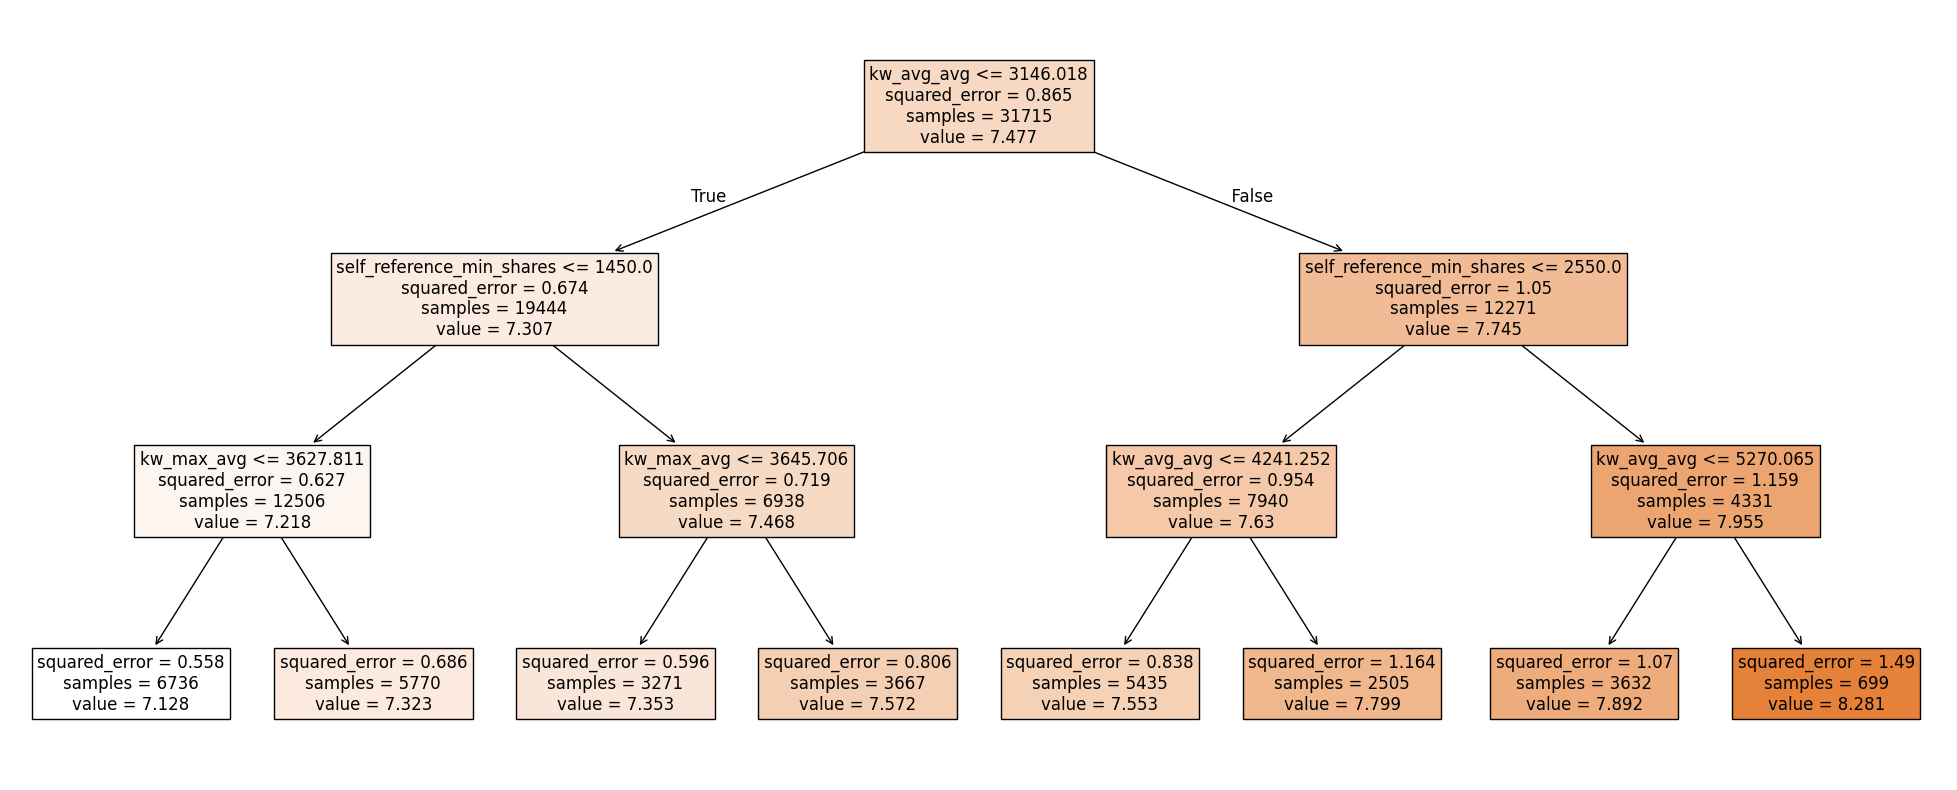

In [214]:
tree_prep = DecisionTreeRegressor(max_depth = 3)
mod_tree = tree_prep.fit(X_train,y_train)
plt.figure(figsize = (25,10))
tree.plot_tree(mod_tree, feature_names=X_final.columns, filled = True,fontsize = 12)

In [215]:
preds = mod_tree.predict(X_test)
r2_score(y_test, preds)

0.0796133048739679

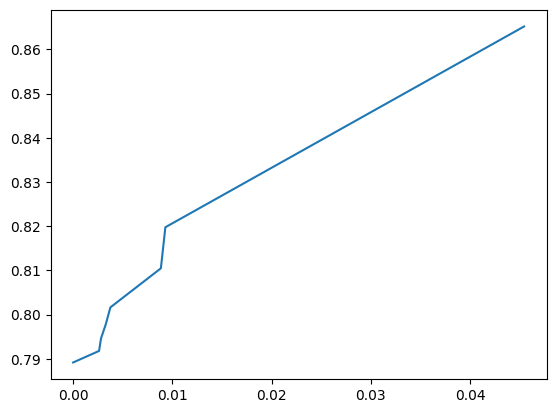

In [216]:
###############################################
# Regression Tree Modeling and Pruning
###############################################
# Fit initial regression tree
tree_prep = DecisionTreeRegressor()
# This code gives a bunch of possible alphas that can be used
path = mod_tree.cost_complexity_pruning_path(X_train,y_train)

ccp_alphas, MSEs = path.ccp_alphas, path.impurities
plt.plot(ccp_alphas,MSEs)

In [217]:
# Create empty vectors to collect in sample and out of sample R^2 values
R2_in = []
R2_out = R2_in.copy()

# Do a loop testing different alphas and calculating in sample and out of sample R^2 values
for ccp_alpha in path.ccp_alphas:
  print(ccp_alpha)
  tree_temp = DecisionTreeRegressor(ccp_alpha=ccp_alpha)
  tree_temp.fit(X_train, y_train)
  R2_in.append(r2_score(y_train,tree_temp.predict(X_train)))
  R2_out.append(r2_score(y_test,tree_temp.predict(X_test)))

0.0
0.002611486170658428
0.0028048859114535862
0.003298158758260089
0.0037507663299194693
0.00883866038698472
0.009291517744165312
0.04542628468838572


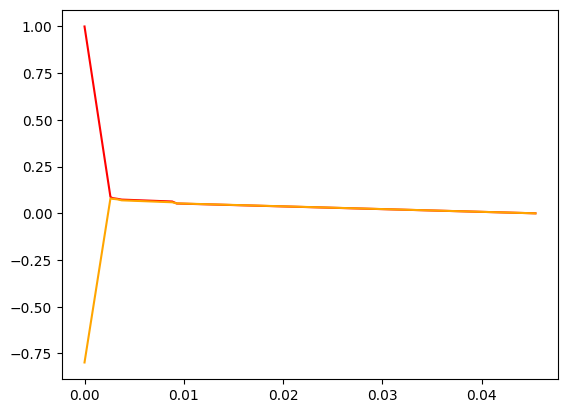

In [218]:
grid = path.ccp_alphas
plt.plot(grid,R2_in,color="r")
plt.plot(grid,R2_out,color = "orange")
plt.show()

In [219]:
# Pair each alpha with its corresponding R^2 value
paired_values = zip(R2_out, path.ccp_alphas)

# Find the pair with the maximum R^2 value
max_R2, best_alpha = max(paired_values)

#best_alpha = path.ccp_alphas[np.argmax(R2_out)]

# Print the alpha that gives the largest R^2
print("Alpha for the largest R^2:", best_alpha)
print("The best R^2 value was:", max_R2)

Alpha for the largest R^2: 0.002611486170658428
The best R^2 value was: 0.079613304873968


### Random Forest Regression Model with Cost-Complexity Pruning

In [220]:
# Fit a random forest regression model, using cost-complexity pruning for the individual trees.

regressor = RandomForestRegressor(n_estimators=1000, random_state=0,ccp_alpha = 0.01, max_depth = 5)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print("In Sample R^2: ",r2_score(y_train,regressor.predict(X_train)))
print("Out Of Sample R^2: ",r2_score(y_test,y_pred))

KeyboardInterrupt: 

In [ ]:
regressor.feature_importances_
dict(zip(X.columns,regressor.feature_importances_))

In [ ]:
pd.Series(regressor.feature_importances_, index=X_final.columns).sort_values().plot(kind='barh')

*Compare each model’s predictive accuracy on the test set. Choose the best-performing model as the final predictive model. Write a concluding section in your technical report that addresses Mashable?s business concerns and presents your final model along with your confidence in its predictions.*


Model Comparisons:
Over the course of this project, we attempted multiple techniques to predict the number of shares an article would receive:

## Linear Regression (with transformations and higher-order terms):
Our linear regression model performed the best among the models tested, achieving an out-of-sample R² of approximately 0.126. While the predictive power was modest, the model highlighted some influential features, such as keywords, topic modeling (LDA features), and content structure.

Regression Tree Modeling:
While regression trees provided some insight into which features might be influential, their overall predictive power was lower than that of our best linear model. Even after pruning, the regression tree struggled to exceed R² values in the low ranges (~0.01), suggesting that a single tree structure is not ideal for this data set.

Practical Guidance:

Based on our best linear regression model, the ideal practices to maximize article shares are as follows:

 * Use Identified Predictors: Focus on features that repeatedly emerged as significant—keywords with certain characteristics, balanced content length, and certain topic distributions—to guide editorial strategies.
Combine Approaches: Consider integrating additional data sources or experimenting with more complex ensemble methods, deep learning models, or custom feature engineering. The complexity of human sharing behavior may require richer data (social context, sentiment analysis, content readability measures) or more advanced modeling techniques.
Expectation Management: Predicting virality remains challenging. Even a well-tuned model only explained a modest portion of variance in share counts. These models should be used as guides rather than definitive predictors.
Conclusion:
The final chosen model, based on the best performance, would be the reduced linear regression model that achieved around a 0.126 out-of-sample R². While not providing a complete predictive solution, this model offers Mashable actionable insights into which content features matter most for shares. We recommend using these insights to inform editorial decisions and potentially integrating additional data and modeling strategies to improve predictive performance in the future.